In [2]:
from pynq import Overlay
from pynq import Xlnk
import matplotlib.pyplot as plt
import numpy as np
import cv2
from time import time
from utils import *
import pickle

In [3]:
# Import and initializing
xlnk = Xlnk()
overlay = Overlay('./overlays/ORB_FPGA.bit')
# overlay = Overlay('./overlays/ORB_clock.bit')
# overlay = Overlay('./overlays/ORB_LAB.bit')

dma_FAST = overlay.axi_dma_fast_in
dma_Gaus = overlay.axi_dma_gaussian_in
dma_des = overlay.axi_dma_descriptor_out

dma_des.recvchannel.start()
dma_FAST.sendchannel.start()
dma_Gaus.sendchannel.start()

# **Read Multiple Images**

In [4]:
HEIGHT = 740
WIDTH = 560
# HEIGHT = 450
# WIDTH = 299
# HEIGHT = 534
# WIDTH = 756
OFFSET = 40
focal_length = 600

img_ori_list = []
src_list = []
num_imgs = 3

start = time()
for i in range(num_imgs):
    print("Processing Image {}...".format(i+1))
    img_ori = cv2.imread('./test_data/'+'BL430_'+str(i+1)+'.jpg')
#     img_ori = cv2.resize(img_ori, (WIDTH, HEIGHT))
#     img_ori = cv2.imread('./clock/'+str(i+1)+'.png')
#     img_ori = cv2.imread('./office/'+str(i+1)+'.png')
    img_ori = cv2.resize(img_ori, (int(WIDTH+0.1*WIDTH), int(HEIGHT+0.1*HEIGHT)))
    img_ori = cylpro(img_ori, focal_length, HEIGHT, WIDTH, OFFSET)
    print(img_ori.shape)
    img_ori_list.append(img_ori)
    img_gray = cv2.cvtColor(img_ori,cv2.COLOR_BGR2GRAY)

    src_buf = xlnk.cma_array(shape=(HEIGHT*WIDTH,), dtype=np.uint8)
    view=np.frombuffer(src_buf,dtype = np.uint8,count = -1)
    np.copyto(view,img_gray.ravel(),casting='same_kind')
    src_list.append(src_buf)
    
des_buf = xlnk.cma_array(shape=(8192,10), dtype=np.int32)
print("Elapse time: {}\n".format(time()-start))

Processing Image 1...
(740, 560, 3)
Processing Image 2...
(740, 560, 3)
Processing Image 3...
(740, 560, 3)
Elapse time: 52.56799530982971



# **Feature Extraction**

In [7]:
des_list = dict()
start = time()
for i in range(len(src_list)):
    
    src_buf = src_list[i]
    dma_FAST.sendchannel.transfer(src_buf)
    dma_Gaus.sendchannel.transfer(src_buf)
    dma_des.recvchannel.transfer(des_buf)
    
    dma_FAST.sendchannel.wait()
    dma_Gaus.sendchannel.wait()
    dma_des.recvchannel.wait()
    
    bytes_read = dma_des.mmio.read(0x58)
    featurePointsNum = int(bytes_read/40) - 1
    print("Processing Image {}...".format(i+1))
    print(str(featurePointsNum)+' feature points are detected')
    
    des_list[i] = des_buf[:featurePointsNum].copy().tolist()
    des_buf.flush()
    src_buf.freebuffer()
print("Elapse time: {}\n".format(time()-start))
dma_des.recvchannel.stop()
dma_FAST.sendchannel.stop()
dma_Gaus.sendchannel.stop()

Processing Image 1...
651 feature points are detected
Processing Image 2...
835 feature points are detected
Processing Image 3...
671 feature points are detected
Elapse time: 0.05462336540222168



In [8]:
#Padding
for i in range(len(des_list)):
    for j in range(1000 - len(des_list[i])):
        des_list[i].append([0,0,0,0,0,0,0,0,0,0])

# **Feature Matching**

In [9]:
xlnk = Xlnk()
overlay = Overlay('./overlays/Feature_Matching.bit')

dma_des1 = overlay.axi_dma_in_1
dma_des2 = overlay.axi_dma_in_2
dma_match = overlay.axi_dma_out


match_list = []
for i in range(num_imgs):
    src_des = np.array(des_list[i], dtype=np.int32)
    src_buf = xlnk.cma_array(shape=(len(src_des)*10,), dtype=np.int32)
    view=np.frombuffer(src_buf,dtype = np.int32,count = -1)
    np.copyto(view,src_des.ravel(),casting='same_kind')
    match_list.append(src_buf)

match_buf = xlnk.cma_array(shape=(2000, ), dtype=np.uint32)

matching_matrix = []
for i in range(num_imgs):
    tmp = []
    for j in range(num_imgs):
        tmp.append([])
    matching_matrix.append(tmp)


start = time()
for i in range(num_imgs):
    for j in range(num_imgs):
        if i < j:
            dma_match.recvchannel.start()
            dma_des1.sendchannel.start()
            dma_des2.sendchannel.start()
#             print("Matching Image {}, {}...".format(i+1,j+1))
            src_buf1 = match_list[i]
            src_buf2 = match_list[j]
            
            dma_des1.sendchannel.transfer(src_buf1)
            dma_des2.sendchannel.transfer(src_buf2)
            dma_match.recvchannel.transfer(match_buf)
            
            dma_des1.sendchannel.wait()
            dma_des2.sendchannel.wait()
            dma_match.recvchannel.wait()

            idx = 0
            matchpoints = []
            while(1):
                if(match_buf[2*idx] != 0):
                    b1 = Bits(int=match_buf[2*idx], length=32)
                    b1 = b1.bin
    
                    b2 = Bits(int=match_buf[2*idx+1], length=32)
                    b2 = b2.bin
    
                    x1 = Bits(bin=b1[0:16]).uint
                    y1 = Bits(bin=b1[16:]).uint

                    x2 = Bits(bin=b2[0:16]).uint
                    y2 = Bits(bin=b2[16:]).uint
                    matchpoints.append([x1,y1,x2,y2])
                    match_buf[2*idx] = 0
                    match_buf[2*idx+1] = 0
                    idx += 1
                else:
                    featurePointsNum = idx 
                    break

#             print(str(featurePointsNum)+' matching points are detected')
            
            #matchpoints = des_buf[:featurePointsNum].copy().tolist()
            matching_matrix[i][j] = matchpoints 
            matching_matrix[j][i] = matchpoints 
            match_buf.flush()
            src_buf1.freebuffer()
            src_buf2.freebuffer()
            
dma_match.recvchannel.stop()
dma_des1.sendchannel.stop()
dma_des2.sendchannel.stop()
print("Matching time:", time()-start)

# Print matching matrix
print("\nMatching Matrix: ")
for i in range(num_imgs):
    for j in range(num_imgs):
        print(len(matching_matrix[i][j]), end='\t')
        if((j+1)%num_imgs == 0):
            print()

Matching time: 3.861595869064331

Matching Matrix: 
0	93	0	
93	0	24	
0	24	0	


# **RANSAC**

In [10]:
stitching_matrix = RANSAC(matching_matrix)
with open('stitching.pkl', 'wb') as f:
    pickle.dump(stitching_matrix, f)

[[   1.  -11.  239.   -1.    0.    0.]
 [   0.   11. -239.    2.    9.  375.]
 [   1.   -9. -375.   -1.    0.    0.]]


In [4]:
with open('stitching.pkl', 'rb') as f:
    stitching_matrix = pickle.load(f)

# **Image Stitching**

Blending Images...
Processing Image 1...
Processing Image 2...
Processing Image 3...
Elapse time: 5.0891358852386475



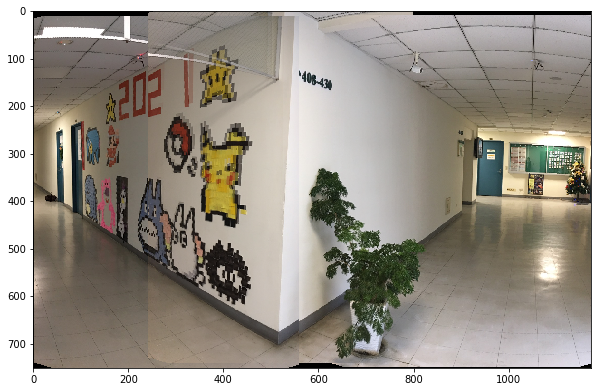

In [11]:
print("Blending Images...")
start = time()
result = stitching(img_ori_list, stitching_matrix)
print("Elapse time: {}\n".format(time()-start))
result = cv2.cvtColor(result,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,7.5))
plt.imshow(result)

In [9]:
cv2.imwrite('./pikachu.png', cv2.cvtColor(result,cv2.COLOR_RGB2BGR))

True